/glade/derecho/scratch/renatob/tmp/ipykernel_91264/3688223621.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.87, 1])  # Adjust layout for colorbar


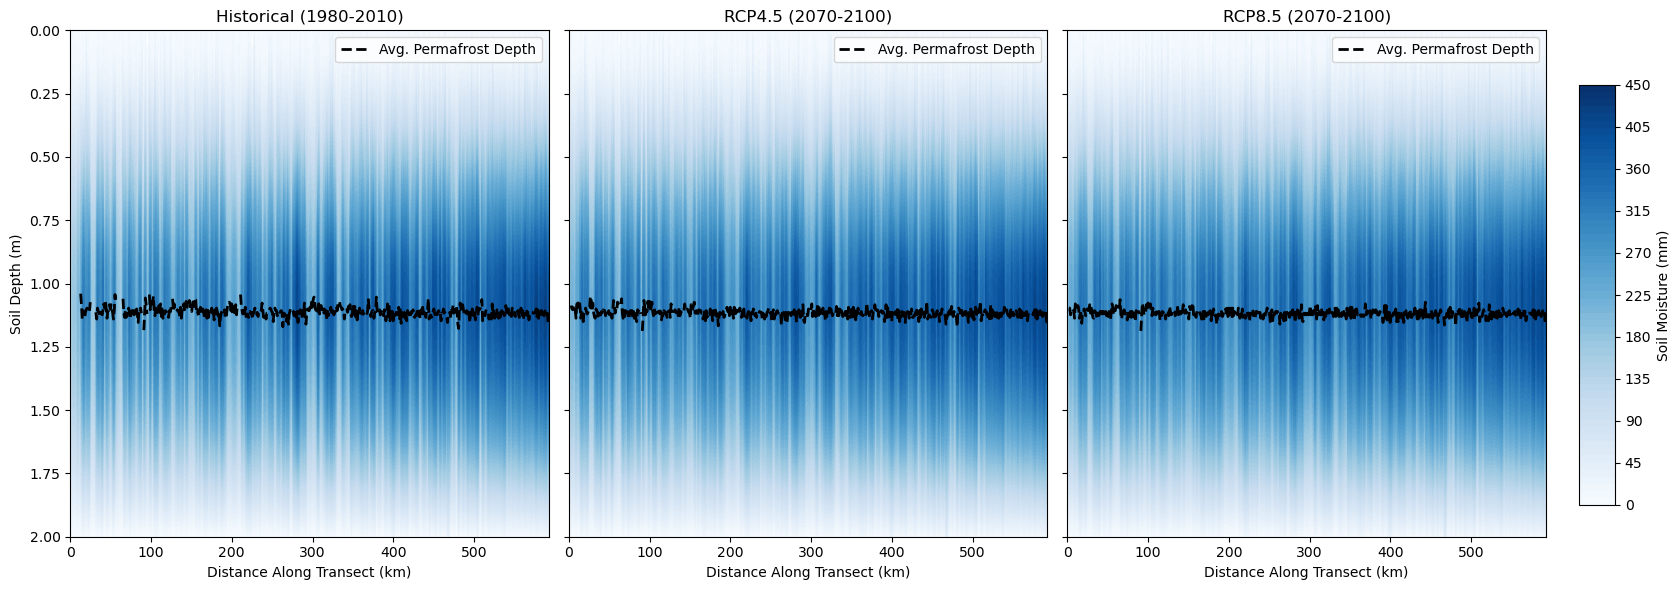

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from geopy.distance import geodesic

# Paths to updated CMIP5 ensemble soil moisture data
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_ws_rcp45.nc"
file_rcp45 = data_dir + "cmip5_ensemble_ws_rcp45.nc"
file_rcp85 = data_dir + "cmip5_ensemble_ws_rcp85.nc"

# Load datasets
datasets = {
    "Historical (1980-2010)": xr.open_dataset(file_hist).sel(time=slice("1980-01-01", "2010-12-31")).mean(dim="time"),
    "RCP4.5 (2070-2100)": xr.open_dataset(file_rcp45).sel(time=slice("2070-01-01", "2100-12-31")).mean(dim="time"),
    "RCP8.5 (2070-2100)": xr.open_dataset(file_rcp85).sel(time=slice("2070-01-01", "2100-12-31")).mean(dim="time")
}

# Define soil depths (meters) and corresponding soil moisture variables (in mm)
depths = {
    "Surface (0.02042 m)": "SM1",
    "Mid-depth (0.97047 m)": "SM2",
    "Deep (2.0 m)": "SM3",
}

# Define station locations (Tok and Canol Trail)
stations = [
    {"name": "Tok", "lon": -142.8089, "lat": 63.3286},
    {"name": "Canol Trail", "lon": -130.98, "lat": 63.25},
]

# Function to extract data along the transect
def select_nearby_points(ds, lon1, lat1, lon2, lat2, buffer_km=25):
    earth_radius_km = 6371.0
    buffer_deg = buffer_km / (earth_radius_km * np.pi / 180)
    lat_min, lat_max = min(lat1, lat2) - buffer_deg, max(lat1, lat2) + buffer_deg
    lon_min, lon_max = min(lon1, lon2) - buffer_deg, max(lon1, lon2) + buffer_deg
    ds_subset = ds.where(
        (ds.latitude >= lat_min) & (ds.latitude <= lat_max) &
        (ds.longitude >= lon_min) & (ds.longitude <= lon_max),
        drop=True
    )
    return ds_subset

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjusted colorbar position

for ax, (scenario, ds) in zip(axes, datasets.items()):
    ds_selected = select_nearby_points(ds, stations[0]["lon"], stations[0]["lat"],
                                       stations[1]["lon"], stations[1]["lat"])
    
    lats = ds_selected.latitude.values.flatten()
    lons = ds_selected.longitude.values.flatten()
    valid_points = ~np.isnan(lats) & ~np.isnan(lons)
    lats, lons = lats[valid_points], lons[valid_points]
    
    total_distance = geodesic((stations[0]["lat"], stations[0]["lon"]), (stations[1]["lat"], stations[1]["lon"])).km
    distances = np.linspace(0, total_distance, len(lats))
    
    moisture_profile = np.array([ds_selected[depth_var].values.flatten()[valid_points] for depth_var in depths.values()])
    moisture_profile = np.vstack([moisture_profile[0], moisture_profile])
    moisture_profile = moisture_profile.T  # Soil moisture in mm
    
    depth_values = np.array([0.0, 0.02042, 0.97047, 2.0])
    
    num_distance_points = 600
    num_depth_points = 300
    
    grid_x = np.linspace(0, total_distance, num_distance_points)
    grid_y = np.linspace(depth_values.min(), depth_values.max(), num_depth_points)
    
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
    grid_z = griddata(
        (np.repeat(distances, len(depth_values)), np.tile(depth_values, len(distances))),
        moisture_profile.flatten(),
        (grid_xx, grid_yy),
        method='cubic'
    )
    
    cmap = plt.get_cmap("Blues")
    abs_max = 450  # Soil moisture in mm, adjusted based on expected values
    levels = np.linspace(0, abs_max, 60)
    
    contour = ax.contourf(grid_xx, grid_yy, grid_z, cmap=cmap, levels=levels)
    ax.invert_yaxis()
    ax.set_title(scenario)
    
    permafrost_depth = np.full_like(grid_x, np.nan)
    for i in range(len(grid_x)):
        below_threshold = grid_y[grid_z[:, i] > 200]  # Assuming permafrost transition near soil moisture ~ 50 mm
        if len(below_threshold) > 0:
            permafrost_depth[i] = np.mean(below_threshold)
    
    ax.plot(grid_x, permafrost_depth, linestyle="dashed", color="black", linewidth=2, label="Avg. Permafrost Depth")
    ax.set_xlabel("Distance Along Transect (km)")
    ax.legend()
    
axes[0].set_ylabel("Soil Depth (m)")
cbar = fig.colorbar(contour, cax=cbar_ax, label="Soil Moisture (mm)")
cbar.set_ticks(np.round(np.linspace(0, abs_max, 11), 0))

plt.tight_layout(rect=[0, 0, 0.87, 1])  # Adjust layout for colorbar
#plt.savefig("Fig_Soil_Moisture_mm.pdf", dpi=300, bbox_inches="tight")
plt.show()
